# 1. IMPORTATIONS AND DATA LOADING

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:/Users/Carlos/Downloads/dia.csv")

In [3]:
df.shape

(100000, 9)

# 2. CLEANING

## 2.1 Duplicates

In [4]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [5]:
df = df.drop_duplicates()

## 2.2 Counting distinct values

In [6]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


## 2.3 Counting null values

In [7]:
# Checking null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


## 2.4 Removing Unncessary values 0.00195%

In [8]:
df = df[df['gender'] != 'Other']

In [9]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


# 5. Correlations

In [25]:
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

smoking_history
non-smoker     67276
past_smoker    19655
current         9197
Name: count, dtype: int64


In [26]:
data = df.copy()

In [27]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

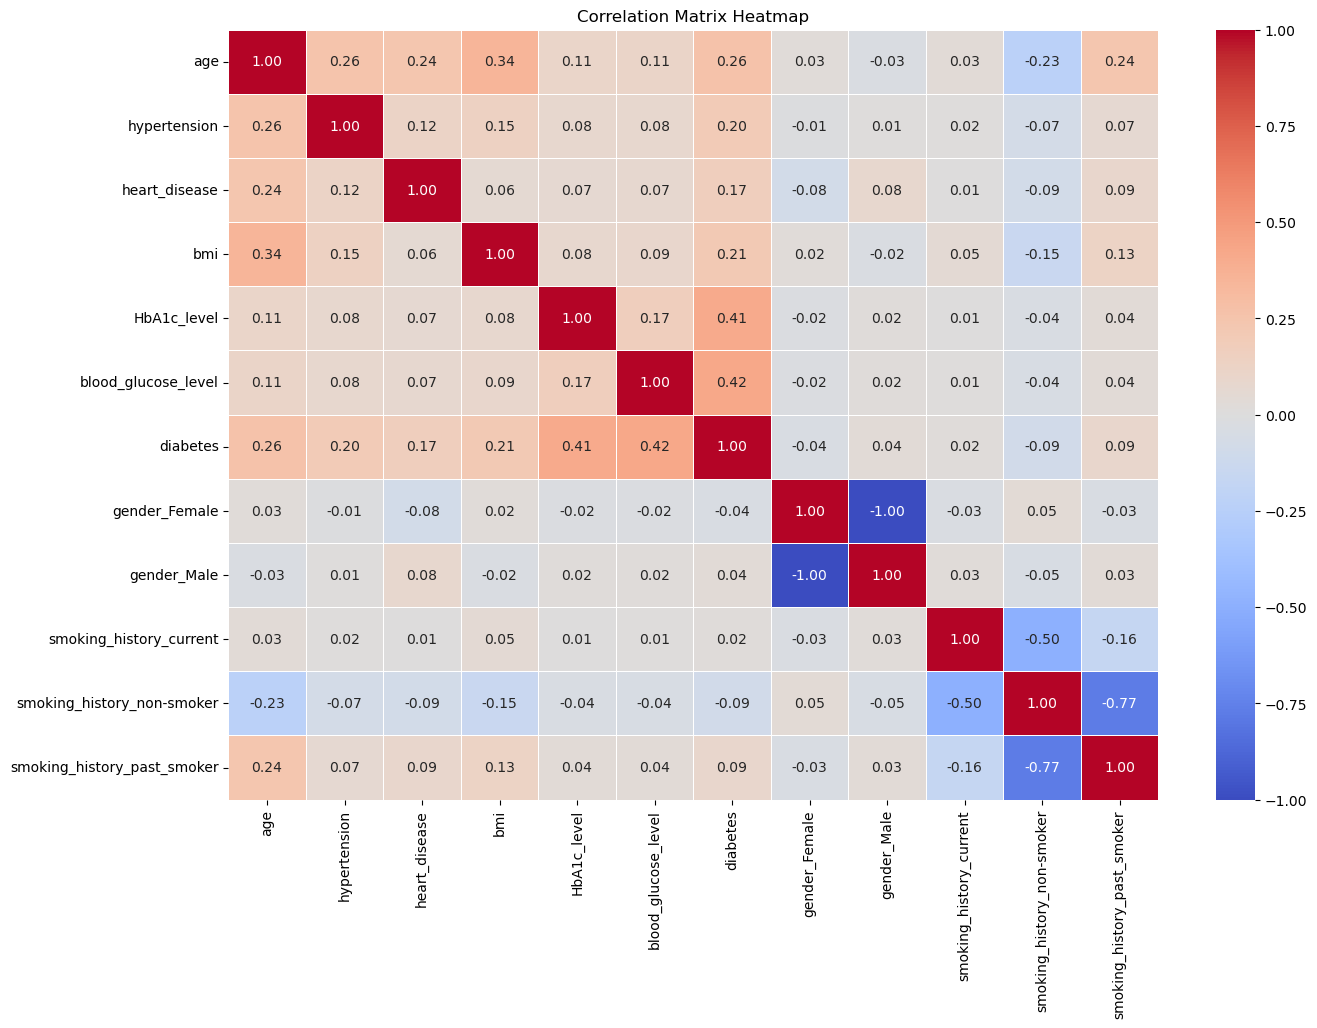

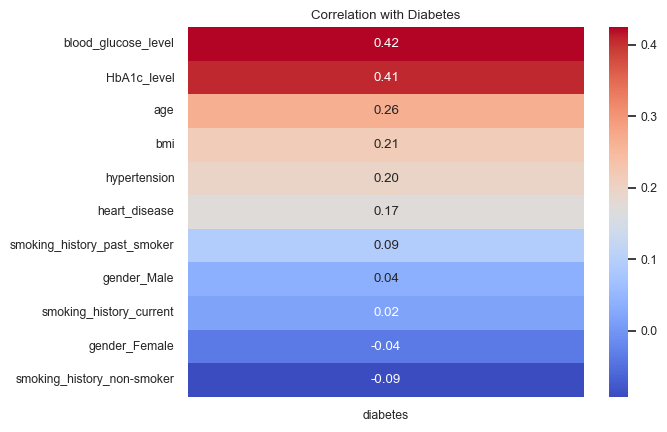

In [28]:
# Compute the correlation matrix
correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

# 6. ML

## 6.0 KKN

In [ ]:
# Librerías adicionales
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# 6.1 Definir características (X) y la variable objetivo (y)
X = data.drop('diabetes', axis=1)  # Todas las características excepto 'diabetes'
y = data['diabetes']  # Variable objetivo 'diabetes'

In [ ]:
# 6.2 Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 6.3 Normalización de características numéricas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 6.4 Definir el modelo KNN
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
# 6.5 Entrenar el modelo KNN
knn.fit(X_train, y_train)

In [ ]:
# 6.6 Predicción en los datos de prueba
y_pred = knn.predict(X_test)

In [ ]:
# 6.7 Evaluación del modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir los valores que vamos a probar
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Configurar el GridSearch
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='recall')

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mejor valor de n_neighbors
print("Best n_neighbors:", grid_search.best_params_)

# Evaluar el modelo con el mejor n_neighbors
y_pred = grid_search.predict(X_test)

## 6.1 Logistic

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
X = df[["age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level",]]
y = df['diabetes']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
log= LogisticRegression()
log.fit(X_train, y_train)

In [ ]:
log.score(X_test,y_test)

In [ ]:
log.score(X_train,y_train)

In [ ]:
y_pred = log.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

In [ ]:
from sklearn.metrics import recall_score

labels = np.unique(y_test)
print("Available labels:", labels)


pos_label = labels[0]

print('Recall:', recall_score(y_test, y_pred, pos_label=pos_label))



In [ ]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 6.2 Random Forest

From the EDA ,the dataset is imbalanced (with 9% positive cases for diabetes and 91% negative cases), it's essential to balance the data to ensure that the model doesn't get biased towards the majority class. For this purpose, the Synthetic Minority Over-sampling Technique (SMOTE) is used, which generates synthetic samples for the minority class.

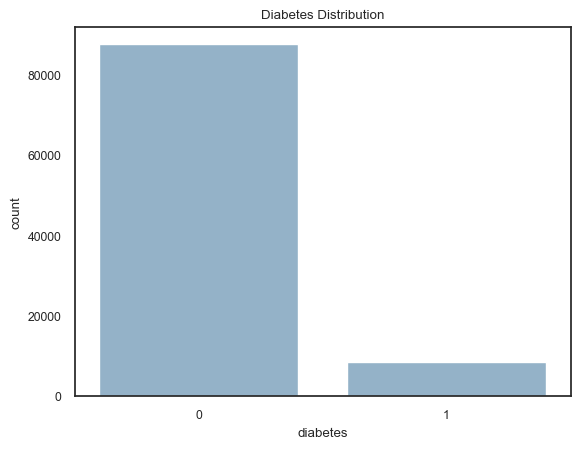

In [29]:
# Count plot for the 'diabetes' variable
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [30]:
#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [31]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

### PROCESSING:SCALER

Preprocessing is a crucial step before training the model. In this case, numerical features are standardized (mean removed and scaled to unit variance), and categorical features are one-hot encoded. Standardization is not required for all models but is generally a good practice. One-hot encoding is necessary for categorical variables to be correctly understood by the machine learning model.

The StandardScaler in sklearn is based on the assumption that the data, Y, follows a distribution that might not necessarily be Gaussian (normal), but we still transform it in a way that its distribution will have a mean value 0 and standard deviation of 1.

In other words, given a feature vector x, it modifies the values as follows:

<p class="formulaDsp">
\[ Y_i = \frac{x_i - \mu(\vec{x})}{\sigma(\vec{x})} \]
</p>

**where:**
<ul>
<li>\( x_i \) is the i-th element of the original feature vector \( \vec{x} \),</li>
<li>\( \mu(\vec{x}) \) is the mean of the feature vector, and</li>
<li>\( \sigma(\vec{x}) \) is the standard deviation of the feature vector.</li>
</ul>

<p>The transformed data \( Y \) (each \( Y_i \)) will have properties such that \( mean(Y) = 0 \) and \( std(Y) = 1 \).</p>

> This transformation is also known as Z-score normalization.

In [33]:
#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [34]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [35]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

### Model Building and Hyperparameter Tuning

A pipeline is constructed which first applies the preprocessing steps and then trains a model on the data. We use a RandomForestClassifier, which is a popular and powerful algorithm for classification tasks. The model's hyperparameters are tuned using GridSearchCV , which performs an exhaustive search over the specified parameter values for the estimator. The best performing model is selected based on cross-validation.

In [36]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [37]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


### Intepret the results



The result shows the best parameters for our Random Forest model that were found during the hyperparameter tuning process:

1. **max_depth of 10:** This indicates that the maximum depth of the trees in the forest is 10 levels. Constraining the depth of the tree helps in reducing overfitting. It appears from this result that a medium-complexity tree works best for our data. Too much complexity (a deeper tree) may capture noise, and too little (a shallower tree) may not capture the underlying structure of the data.

2. **min_samples_leaf of 2:** This means that each leaf (the end node of a decision tree, where predictions are made) must contain at least two samples. This parameter, like max_depth, is a way to control overfitting. By requiring at least two samples to make a prediction, the model prevents fitting to outliers or noise in the training data.

3. **min_samples_split of 2:** This tells us that a node must contain at least two samples in order to be split (to create two child nodes). Similar to the min_samples_leaf parameter, this can help control overfitting.

4. **n_estimators of 50:** This is the number of decision trees in the forest. The Random Forest algorithm works by averaging the predictions of many decision trees to make a final prediction, which helps reduce overfitting and variance. In this case, it seems that having 50 trees in the forest gives us the best performance.


These parameters are a result of the Hyperparameter tuning process , and they give us insight into the structure of the data and the complexity of the model that best captures that structure. The moderately constrained tree depth and the requirements for the number of samples at each node suggest a model that is complex enough to capture the important patterns in the data, but not so complex that it overfits to noise or outliers.This balance is crucial in creating a model that will generalize well to new data.

Remember, these are the optimal parameters given the parameter grid we defined and the specific dataset at hand. For a **different dataset** or with a **different parameter grid**, **the optimal parameters could be different.**

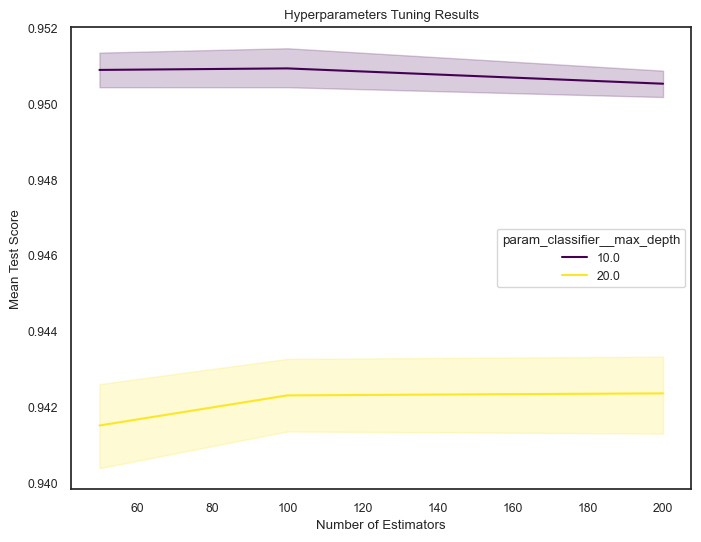

In [38]:
# Convert GridSearchCV results to a DataFrame and plot
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

### Confusion Matrix

The trained model is evaluated on the **test set**. Confusion matrix is used to visualize the performance of the model. It shows the true positive, true negative, false positive, and false negative predictions of the model.

Precision:

Precision is a measure of how many of the true positive predictions were actually correct. It is defined as the number of true positives (TP) divided by the sum of true positives (TP) and false positives (FP).

\[ Precision = \frac{TP}{TP + FP} \]


Recall:

Recall (or Sensitivity) is a measure of how many of the actual positive cases were identified correctly. It is defined as the number of true positives (TP) divided by the sum of true positives (TP) and false negatives (FN).

\[ Recall = \frac{TP}{TP + FN} \]

F1-Score:

The F1 score is the harmonic mean of Precision and Recall and tries to find the balance between precision and recall. It is defined as 2 times the product of precision and recall divided by the sum of precision and recall.

<br>

\[ F1 Score = \frac{2 * Precision * Recall}{Precision + Recall} \]

    
In all of these formulas:
    
True Positives (TP) are the cases in which we predicted yes (diabetes present), and the actual was also yes.
True Negatives (TN) are the cases in which we predicted no, and the actual was also no.
False Positives (FP) are the cases in which we predicted yes, but the actual was no.
False Negatives (FN) are the cases in which we predicted no, but the actual was yes.

Model Accuracy:  0.9495474877769687
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     17525
           1       0.68      0.80      0.74      1701

    accuracy                           0.95     19226
   macro avg       0.83      0.88      0.85     19226
weighted avg       0.95      0.95      0.95     19226



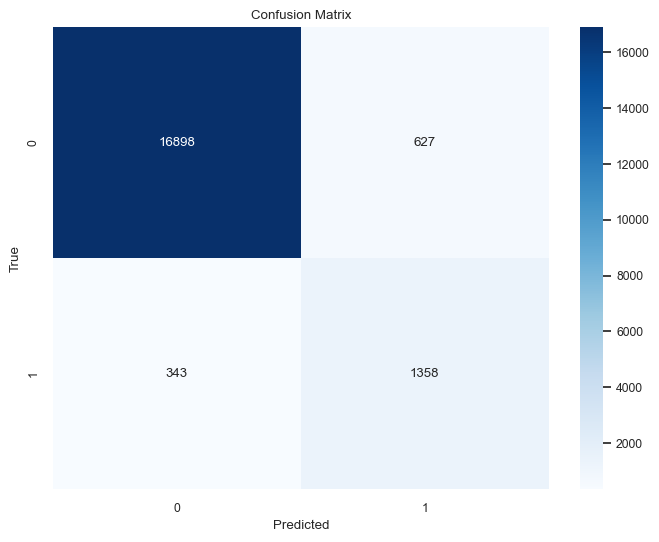

In [39]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Intepret the results

Our trained Random Forest Model achieved an accuracy of around 95%. This indicates that the model correctly classified around 95% of all cases in the test set.

Looking deeper into the classification metrics, let's dissect the performance for each class (0 and 1) separately:

A | Class 0 (Non-diabetes):
- The model has a high precision (0.98) for class 0, meaning that among all instances where the model predicted non-diabetes, 98% were indeed non-diabetes. 
- The recall for class 0 is also high (0.96). This means that our model correctly identified 96% of all actual non-diabetes cases in the dataset. 

B | Class 1 (Diabetes): 
- The precision for class 1 is lower around (0.65), which indicates that when the model predicted diabetes, it was correct around 65% of the time. 
- However, the recall is reasonably high around (0.80). This means that our model was able to capture around 80% of all actual diabetes cases. 

The F1 score, a harmonic mean of precision and recall, is around 0.97 for class 0 and around 0.72 for class 1. The weighted average F1 score is around 0.94, in line with the overall accuracy.

This discrepancy in performance between classes is likely due to the imbalance in the original dataset. Class 0 (Non-diabetes) is the majority class and has more examples for the model to learn from.

> However, the higher recall for class 1 (Diabetes) is promising. This is an essential aspect for a healthcare model, as missing actual positive cases (false negatives) can have serious implications. 

    
In summary, while our model performs well overall, it particularly excels with the majority class (non-diabetes). To enhance performance on the minority class (diabetes), we can further address class imbalance or adjust model parameters. Despite these areas for improvement, the model's ability to accurately identify a high percentage of actual diabetes cases is encouraging at this early stage of model development. Subsequent iterations and refinements are expected to enhance precision in diabetes predictions without compromising recall.    

### 5. Feature Importance

Finally, the importance of each feature is computed. This is the total decrease in node impurity (weighted by the probability of reaching that node, which is approximated by the proportion of samples reaching that node) averaged over all trees of the ensemble. **The feature importance gives insight into which features are most useful for making predictions.** The features are ranked by their importance and visualized using a bar plot.

                        Feature  Importance
2                   HbA1c_level    0.445258
3           blood_glucose_level    0.323844
0                           age    0.116680
1                           BMI    0.062051
4                  hypertension    0.022085
5                 heart_disease    0.019549
10  smoking_history_past_smoker    0.003333
9    smoking_history_non-smoker    0.003322
7                   gender_Male    0.001642
6                 gender_Female    0.001538
8       smoking_history_current    0.000699


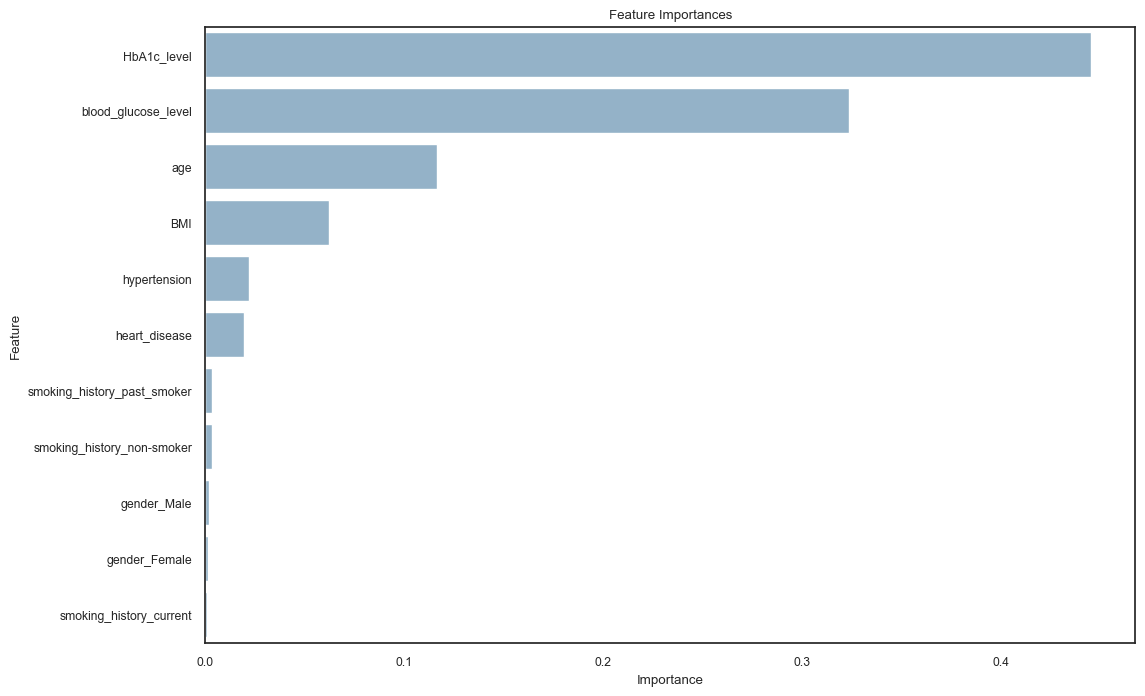

In [40]:
# After fitting the model, we input feature names
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))

# Then we add the numeric feature names
feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

# And now let's get the feature importances
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

### Intepret the results

The feature importance results provide insight into which features are most influential in predicting diabetes using our Random Forest Model. The importance of a feature is calculated based on how much the tree nodes that use that feature reduce impurity across all trees in the forest.

Here are the key findings from the feature importance results:

1. **`HbA1c_level`** is the most important feature with an importance of 0.44. HbA1c is a measure of the average levels of blood glucose over the past 2 to 3 months, so it's not surprising that it's a significant predictor of diabetes.

2. **`The blood_glucose_level`** the second most important feature with an importance of 0.32. This aligns with medical knowledge, as blood glucose levels are directly used to diagnose diabetes.

3. **`Age`** the third most important feature with an importance of 0.14. It's well known that the risk of type 2 diabetes increases as you get older.

4. **`BMI`** comes fourth in terms of importance at 0.06. Body Mass Index is a key risk factor for diabetes, and its role is well documented in medical literature.

5. Other features like **`hypertension`** and **`heart_disease`** show some importance (0.02 and 0.01, respectively), indicating that these health conditions might have some relevance in predicting diabetes, though not as significant as the top four factors.

6. **`Smoking history`** ('smoking_history_non-smoker', 'smoking_history_past_smoker', 'smoking_history_current') and **`gender`** ('gender_Female', 'gender_Male') are shown to have minimal or zero importance in our model. This could be due to a number of reasons including that these factors may not be as influential in the development of diabetes or it could be a result of how the data was collected or structured.